In [24]:
import xarray as xr
from utils.function_clns import subsetting_pipeline
import numpy as np

path = "/media/BIFROST/N2/Riccardo/MSG/msg_data/NDVI/archive.eumetsat.int/umarf-gwt/onlinedownload/riccardo7/4859700/temp/time/ndvi_eumetsat.nc"
chunks ={'time': -1, "lat": 250, "lon":250}
ds = xr.open_dataset(path, engine="netcdf4", chunks=chunks)

ds = subsetting_pipeline(ds).rename({"Band1":"ndvi"})
ds["ndvi"] = xr.where(ds["ndvi"]==255, np.NaN, ds["ndvi"])
ndvi = ds["ndvi"]/100

ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [27]:
np.unique(ndvi.values)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.81, 0.82, 0.83, 0.85, 0.86, 0.88, 0.89, 0.93,
       0.98, 1.  ,  nan], dtype=float32)

In [2]:
import os
from utils.function_clns import config, prepare, subsetting_pipeline

dataset = prepare(subsetting_pipeline( 
            xr.open_dataarray(os.path.join(config['NDVI']['ndvi_path'], 
            "ndvi_smoothed_w2s.nc"),chunks=chunks))).transpose("time","lon","lat")


/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 250. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 250. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation

In [8]:
import pandas as pd
import xesmf as xe
ndvi = prepare(ndvi)

regridder = xe.Regridder(ndvi, dataset, 'bilinear')

# Reproject the entire dataset
ds_reprojected = regridder(ndvi)
ds_reprojected = ds_reprojected.transpose("time","lon","lat")

print(dataset.rio.resolution())
print(ds_reprojected.rio.resolution())

ds_reprojected = ds_reprojected.drop_duplicates(dim=["time"])
#dataset = dataset.sel(time=slice(ds_reprojected.time.min(), ds_reprojected.time.max()))

ds_reprojected['time'] = pd.to_datetime(ds_reprojected['time'].values, format='%Y-%m-%d')
ds_reprojected['time'] =  ds_reprojected.indexes["time"].normalize()
dataset['time'] = pd.to_datetime(dataset['time'].values, format='%Y-%m-%d')
dataset['time'] =  dataset.indexes["time"].normalize()

# Find the common time values between ds1 and ds2
common_times = xr.align(ds_reprojected['time'], dataset['time'])[0].values
# Select only the common time values in ds1 and ds2
ds1_filtered = dataset.sel(time=common_times)
ds_2_filtered = ds_reprojected.sel(time=common_times)

ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


(0.043782177927351104, 0.04378217792735114)
(0.043782177927351104, 0.04378217792735114)


In [32]:
import xskillscore as xs
corr = xs.pearson_r(ds1_filtered, ds_2_filtered, dim="time", skipna=True)
rmse = xs.rmse(ds1_filtered, ds_2_filtered, dim="time", skipna=True)
mae = xs.mae(ds1_filtered, ds_2_filtered, dim="time", skipna=True)
mape = xs.mape(ds1_filtered, ds_2_filtered, dim="time", skipna=True)

/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


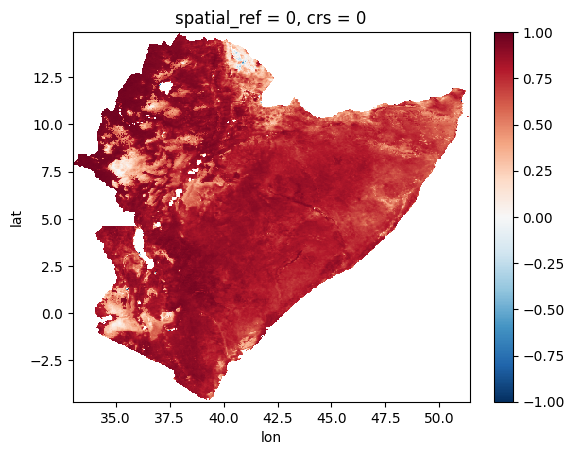

In [42]:
corr.transpose("lat","lon").plot()

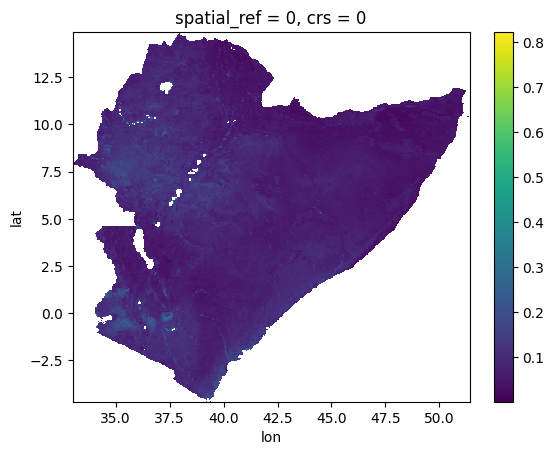

In [39]:
rmse.transpose("lat","lon").plot()

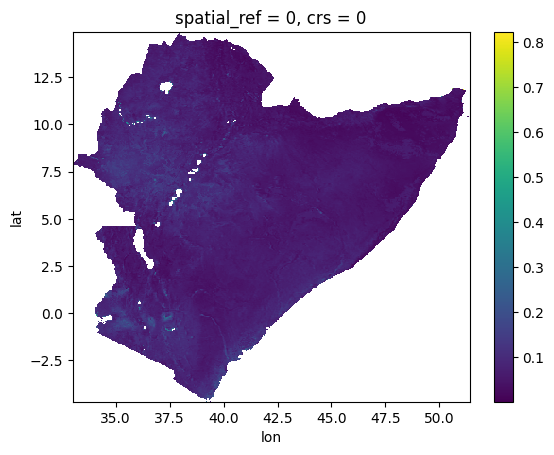

In [40]:
mae.transpose("lat","lon").plot()

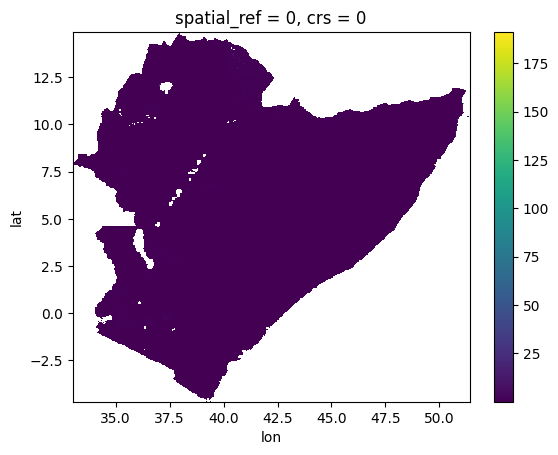

In [41]:
mape.transpose("lat","lon").plot()

In [37]:
print("mean correlation is", corr.mean().values)
print("mean rmse is", rmse.mean().values)
print("mean mae is", mae.mean().values)
print("mean mape is", mape.mean().values)

/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


mean correlation is 0.76396963157066
mean rmse is 0.07884886263440524
mean mae is 0.06757304910504819
mean mape is 0.36486936450701807


In [1]:
from utils.function_clns import config 
import os
import xarray as xr

chunks ={'time': -1, "lat": 250, "lon":250}

path_lai = config["LAI"]["path"]
lai = xr.open_mfdataset(os.path.join(path_lai, "*.nc"), chunks=chunks)

/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 250. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 250. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 250. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xarray/core/dataset.py:282: UserWarning: Th

In [5]:
from utils.function_clns import subsetting_pipeline
lai_ds = subsetting_pipeline(lai)

ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ install

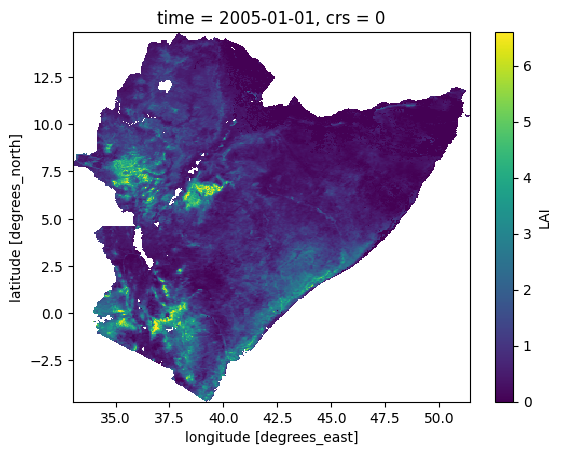

In [9]:
lai_ds.LAI.isel(time=0).plot()

In [30]:
import pandas as pd
import xesmf as xe
lai_ds = prepare(lai_ds)

regridder = xe.Regridder(dataset, lai_ds, 'bilinear')

# Reproject the entire dataset
ds_reprojected = regridder(dataset)
#ds_reprojected = ds_reprojected.transpose("time","lon","lat")

print(lai_ds.rio.resolution())
print(ds_reprojected.rio.resolution())

ds_reprojected = ds_reprojected.drop_duplicates(dim=["time"])
lai_ds = lai_ds.drop_duplicates(dim=["time"])

#dataset = dataset.sel(time=slice(ds_reprojected.time.min(), ds_reprojected.time.max()))

ds_reprojected['time'] = pd.to_datetime(ds_reprojected['time'].values, format='%Y-%m-%d')
ds_reprojected['time'] =  ds_reprojected.indexes["time"].normalize()
lai_ds['time'] = pd.to_datetime(lai_ds['time'].values, format='%Y-%m-%d')
lai_ds['time'] =  lai_ds.indexes["time"].normalize()

# Find the common time values between ds1 and ds2
common_times = xr.align(ds_reprojected['time'], lai_ds['time'])[0].values
# Select only the common time values in ds1 and ds2
ds1_filtered = lai_ds.sel(time=common_times).chunk(chunks)
ds2_filtered = ds_reprojected.sel(time=common_times).chunk(chunks)

ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


(0.05000001663083276, -0.05)
(0.05000001663083276, -0.05)


/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [47]:
start_date = '2008-01-01'
end_date = '2020-01-01'

# Create a date range for the 1st, 11th, and 21st of each month
date_range = pd.date_range(start=start_date, end=end_date, freq='10D')

# Filter the dates to include only the 1st, 11th, and 21st
dates = date_range[date_range.day.isin([1, 11, 21])]

date_range

DatetimeIndex(['2008-01-01', '2008-01-11', '2008-01-21', '2008-01-31',
               '2008-02-10', '2008-02-20', '2008-03-01', '2008-03-11',
               '2008-03-21', '2008-03-31',
               ...
               '2019-09-30', '2019-10-10', '2019-10-20', '2019-10-30',
               '2019-11-09', '2019-11-19', '2019-11-29', '2019-12-09',
               '2019-12-19', '2019-12-29'],
              dtype='datetime64[ns]', length=439, freq='10D')

In [60]:
len(all_dates)

468

In [32]:
import xskillscore as xs
corr = xs.pearson_r(ds1_filtered, ds2_filtered, dim="time", skipna=True)

/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


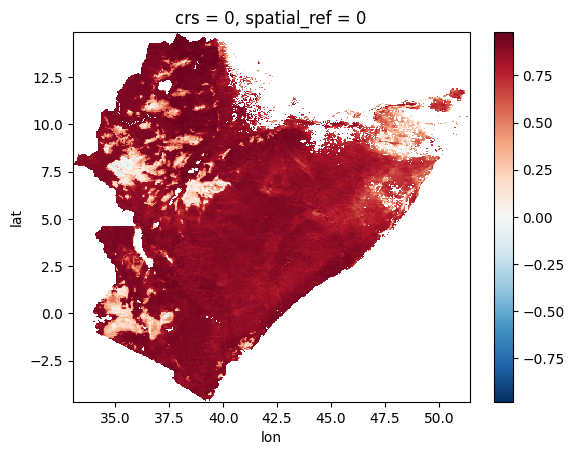

In [34]:
corr.plot()

In [1]:
import xarray as xr 
import os
from vegetation.preprocessing.ndvi_clean import load_landsaf_ndvi

path = "/media/BIFROST/N2/Riccardo/output"
target_store = "output_file.zarr"
zarr_path = os.path.join(path, target_store)
ds = load_landsaf_ndvi(zarr_path)

ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
